In [36]:
from __future__ import annotations
from numbers import Number
from typing import Callable, Union
import sympy as sy
from sympy import exp, cosh, sinh, Expr, Symbol
sy.init_printing()
Value = Union[Expr, Number]
Simplifier = Callable[[Expr], Expr]

In [37]:
def coefficient(expr: Expr, symb: Symbol, where: Value, order: int) -> Expr:
    """Coefficient in a power series expansion.

    Parameters
    ----------
    expr : sympy.Expr
        The expression being expanded in a power series.
    symb : sympy.Symbol
        The variable wrt which `expr` is being expanded.
    where : sympy.Expr|Number
        The value of `symb` about which `expr` is expanded.
    order : int
        The exponent of the term whose coefficient we want.

    Returns
    -------
    coeff : sympy.Expr
        The coefficient of `(symb - where)**order` in `expr`.
    """
    return sy.residue(expr / (symb - where)**(order+1), symb, where)

In [38]:
def simplify_coeff(expr: Expr) -> Expr:
    """Simplify coefficient in a series

    Parameters
    ----------
    expr : Expr
        The coefficient to be simplified.

    Returns
    -------
    new_expr : Expr
        Simplified coefficient
    """
    return sy.collect(sy.expand(expr), [w, c], lambda x: sy.factor(x.subs(m, m+1)).subs(m, m-1))
    return sy.collect(sy.expand(expr), [w, c], sy.factor)

In [39]:
def simplify_series(expr: Expr, symb: Symbol, where: Value, lo: int, hi: int,
                    simpl: Simplifier = simplify_coeff) -> Expr:
    """Simplify coefficients in a series

    Parameters
    ----------
    expr : sympy.Expr
        The expression being expanded in a power series.
    symb : sympy.Symbol
        The variable wrt which `expr` is being expanded.
    where : sympy.Expr|Number
        The value of `symb` about which `expr` is expanded.
    lo : int
        Lowest power of `(symb - where)` that appears in `expr`.
    hi : int
        Highest power of `(symb - where)` that appears in `expr`.
    simpl: Callable[Expr -> Expr], optional
        Function that performs simplification, by default `sympy.factor`.

    Returns
    -------
    new_expr : sympy.Expr
        Simplified version of `expr`.
    """
    result = sy.S.Zero
    for pwr in range(lo, hi+1):
        result += simpl(coefficient(expr, symb, where, pwr)) * (symb - where)**pwr
    return result

In [40]:
beta, B, C = sy.symbols('beta B C', real=True)
eps, delta, s = sy.symbols('epsilon delta s', real=True, positive=True)
b, c, w = sy.symbols('b c w', integer=True)
m, i, j = sy.symbols('m i j', integer=True, positive=True)
one, two, three = sy.Integer(1), sy.Integer(2), sy.Integer(3)

In [41]:
subs0 = (s, (exp(beta) + exp(-beta)) / 2 - 1)
subs1 = (exp(beta*m), cosh(beta*m) + sinh(beta*m))
subs2 = ((cosh(beta*m) + sinh(beta*m))**2,
         (cosh(beta*m) + sinh(beta*m))
         / (cosh(beta*m) - sinh(beta*m)))
subs3 = (exp(beta), cosh(beta) + sinh(beta))
subs4 = ((cosh(beta) + sinh(beta))**2,
         (cosh(beta) + sinh(beta))
         / (cosh(beta) - sinh(beta)))
subs5 = (i, (c+1)/2 + m)
subs6 = (c, (i - m)*2 + 1)
subs7 = (eps, 1-delta)

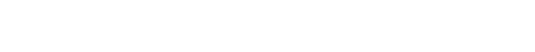

In [42]:
eq1 = (1-eps)/2 * (B * exp(beta) + C * exp(-beta)) - (s + (1-eps)/2) * (B + C)
eq2 = (B * exp((m-2)*beta) + C * exp(-(m-2)*beta)) / 2 - (s + three/2) *  (B * exp((m-1)*beta) + C * exp(-(m-1)*beta))
eq2

In [43]:
sol = sy.linsolve([eq1.subs(*subs0), eq2.subs(*subs0) - 1/s], (B, C))
Bsol, Csol = sol.args[0]


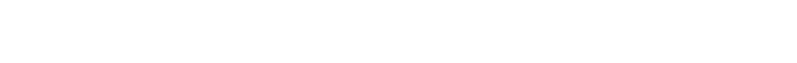

In [44]:
sy.factor(sy.simplify(Bsol)), sy.factor(sy.simplify(Csol))

In [45]:
Bcore = sy.factor(Bsol * (exp(beta) + 1))
Ccore = sy.factor(Csol * (exp(beta) + 1))

In [46]:
Bsimp = sy.collect(sy.simplify(Bcore.subs([subs1, subs2])), [cosh(beta*m), sinh(beta*m)]).subs([subs3, subs4])
Csimp = sy.collect(sy.simplify(Ccore.subs([subs1, subs2])), [cosh(beta*m), sinh(beta*m)]).subs([subs3, subs4])

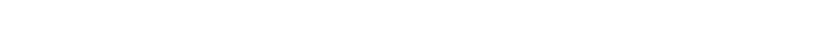

In [47]:
Bfinal = sy.trigsimp(sy.simplify(Bsimp) / (exp(beta) + 1))
Cfinal = sy.trigsimp(sy.simplify(Csimp) / (exp(beta) + 1))
Bfinal, Cfinal

In [48]:
Bser = sy.series(Bfinal.subs(*subs0), beta, 0, 3)
Cser = sy.series(Cfinal.subs(*subs0), beta, 0, 3)

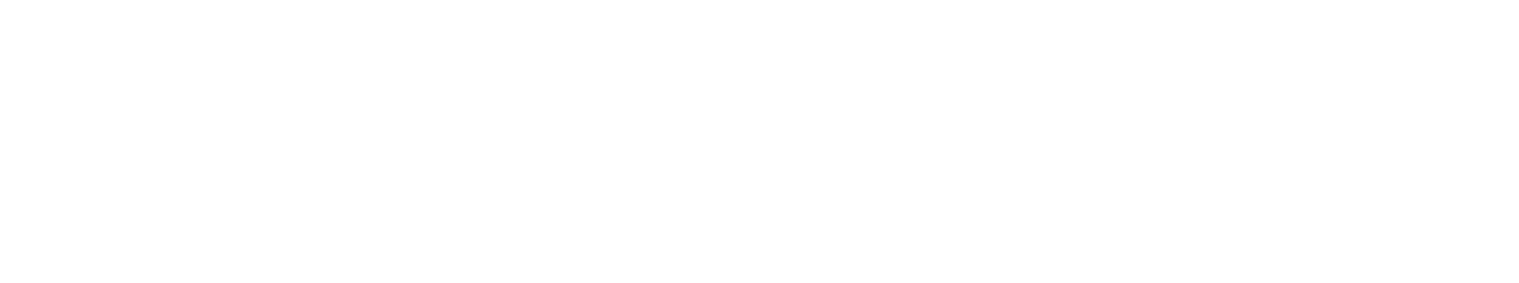

In [49]:
deta = sy.series(1/subs0[1] + Bser * exp(beta*(i-1)) + Cser * exp(-beta*(i-1)), beta, 0, 3)
eta_s = sy.series(sy.simplify(deta), eps, 1, 2).subs(*subs7)
eta_s

In [50]:
eta_neg = eta_s.subs(beta, 0).subs(*subs5)
eta_p_neg = sy.diff(eta_s, beta, 2).subs(beta, 0).subs(*subs5)
eta_def = (1 - w)/2 * eta_neg - (1 + w)/2 * eta_neg.subs(c, -c)
eta_p_def = (1 - w)/2 * eta_p_neg - (1 + w)/2 * eta_p_neg.subs(c, -c)

In [51]:
eta_ser = sy.series(sy.expand(eta_def), delta, 0, 2)
eta = simplify_series(eta_ser, delta, 0, -2, 2)

In [52]:
eta_p_ser = sy.series(sy.expand(eta_p_def), delta, 0, 2)
eta_p = simplify_series(eta_p_ser, delta, 0, -2, 2)

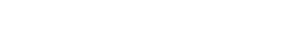

In [53]:
eta

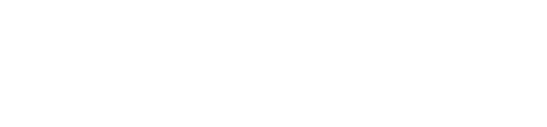

In [54]:
eta_p

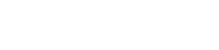

In [55]:
a_mid_def = (eta.subs(c, c-2) - eta.subs(c, c+2)) / 2
a_end_def = sy.expand((eta.subs(c, w*(2*m - 3)) - eta.subs(c, w*(2*m - 1))) * w*delta/2).subs(w**2, 1)
simplify_series(a_mid_def, delta, 0, -1, 2), simplify_series(a_end_def, delta, 0, -1, 2)

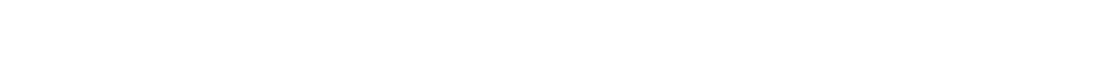

In [56]:
ap_mid_def = (eta_p.subs(c, c-2) - eta_p.subs(c, c+2)) / 2
ap_end_def = sy.expand((eta_p.subs(c, w*(2*m - 3)) - eta_p.subs(c, w*(2*m - 1))) * w*delta/2).subs(w**2, 1)
simplify_series(ap_mid_def, delta, 0, -2, 2), simplify_series(ap_end_def, delta, 0, -2, 2)

In [57]:
subs = [(c, 2*i - 1), (w, 1)]
denom = one + delta * (m-1)
area = sy.Sum(a_mid_def.subs(subs), (i, 1, m-1)).doit() * delta + a_end_def
area_p = sy.Sum(sy.simplify(ap_mid_def.subs(subs)), (i, 1, m-1)) * delta + ap_end_def

In [58]:
simplify_series(area / denom, delta, 0, -2, 1)

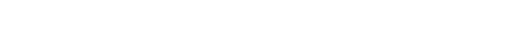

In [59]:
simplify_series(sy.simplify(area_p) / denom, delta, 0, -2, 1)